In [1]:
%%capture
cd ..

In [2]:

from model import Matuszynska2016

In [3]:
from modelbase2 import Simulator, make_protocol, plot
import itertools as it
from typing import cast
from tqdm.notebook import tqdm
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import sqlite3

In [4]:
Matuszynska2016().get_stoichiometries()

,v_PSII,v_PQ,v_ATPsynth,v_Leak,v_ATPcons,v_ATPact,v_Xcyc,v_PsbSP
PQH_2,1.00,-1.00,0.000000,0.00,0.0,0.0,0.0,0.0
H_lu,0.02,0.04,-0.046667,-0.01,0.0,0.0,0.0,0.0
ATP_st,0.00,0.00,1.000000,0.00,-1.0,0.0,0.0,0.0
ATPase_ac,0.00,0.00,0.000000,0.00,0.0,1.0,0.0,0.0
Vx,0.00,0.00,0.000000,0.00,0.0,0.0,-1.0,0.0
psbS,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,-1.0


In [5]:
def pam2(
    s: Simulator,
    t_relax: float, #Duration of relaxtion
    t_pulse: float, #Duration of Pulse
    numpeaks_phase0: float,
    numpeaks_phase1: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    max_duration: float = 2500,
):
    step_duration = t_relax + t_pulse
    max_steps = int(max_duration // step_duration) + 1
    
    pfds = list(
        [pfd_dark, pfd_pulse] * numpeaks_phase0 + [pfd_illumination, pfd_pulse] * numpeaks_phase1 + [pfd_dark, pfd_pulse] * (max_steps - (numpeaks_phase0 + numpeaks_phase1))
        
    )
    time_points = list(it.chain.from_iterable((t_relax, t_pulse) for i in range(max_steps)))
    
    ptrc = [
        (t_end, {'pfd': pfd}) for t_end, pfd in zip(time_points, pfds)
    ]
    
    pam_ptrc = make_protocol(ptrc)
    
    s.simulate_over_protocol(pam_ptrc, 100)
    
    return s, pam_ptrc

def npq2(
    s: Simulator,
    peak_distance: float
):
    
    fluo_results = s.get_full_concs()['Fluo'] / max(s.get_full_concs()['Fluo'])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = s.get_full_concs().iloc[peaks].index
    
    # Calculate Fm
    Fm = fluo_results.iloc[peaks].values
    
    #Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = s.get_full_concs()['Fluo'].iloc[prominences_left].values
    
    return time, Fm, NPQ, Fo

## Experimental Data

In [6]:
def figure4_data(
    data: pd.DataFrame,
):
    df_arabi = data[data.Specie == "Arabidopsis"].copy()
    
    res = []
    
    for lightintensity, darkduration in zip([100, 300, 900], [15, 30, 60]):
        df_arabi_li = df_arabi[df_arabi.LightIntensity == lightintensity].copy()
        df_arabi_li_dd = df_arabi_li[df_arabi_li.DarkDuration == darkduration].copy()
        df_arabi_li_dd['Time'] = pd.to_timedelta(df_arabi_li_dd['Time'])
        
        df_arabi_li_dd_1 = df_arabi_li_dd[df_arabi_li_dd['Replicate'] == 1].copy()
        df_arabi_li_dd_2 = df_arabi_li_dd[df_arabi_li_dd['Replicate'] == 2].copy()
        df_arabi_li_dd_3 = df_arabi_li_dd[df_arabi_li_dd['Replicate'] == 3].copy()

        df_arabi_li_dd_1['Timedelta'] = (df_arabi_li_dd_1['Time'] - df_arabi_li_dd_1['Time'].iloc[0]).apply(lambda x: x.total_seconds())
        df_arabi_li_dd_1['Fm_rel'] = (df_arabi_li_dd_1['Fm'] / df_arabi_li_dd_1['Fm'].iloc[0])
        df_arabi_li_dd_1['Ft_rel'] = (df_arabi_li_dd_1['Ft'] / df_arabi_li_dd_1['Fm'].iloc[0])
        df_arabi_li_dd_2['Timedelta'] = (df_arabi_li_dd_2['Time'] - df_arabi_li_dd_2['Time'].iloc[0]).apply(lambda x: x.total_seconds())
        df_arabi_li_dd_2['Fm_rel'] = (df_arabi_li_dd_2['Fm'] / df_arabi_li_dd_2['Fm'].iloc[0])
        df_arabi_li_dd_2['Ft_rel'] = (df_arabi_li_dd_2['Ft'] / df_arabi_li_dd_2['Fm'].iloc[0])
        df_arabi_li_dd_3['Timedelta'] = (df_arabi_li_dd_3['Time'] - df_arabi_li_dd_3['Time'].iloc[0]).apply(lambda x: x.total_seconds())
        df_arabi_li_dd_3['Fm_rel'] = (df_arabi_li_dd_3['Fm'] / df_arabi_li_dd_3['Fm'].iloc[0])
        df_arabi_li_dd_3['Ft_rel'] = (df_arabi_li_dd_3['Ft'] / df_arabi_li_dd_3['Fm'].iloc[0])

        df_arabi_li_dd = pd.concat([df_arabi_li_dd_1, df_arabi_li_dd_2, df_arabi_li_dd_3])
        
        df_arabi_li_dd_mean = df_arabi_li_dd[['Timedelta', 'Fm_rel', 'Ft_rel', 'ExpId']].groupby('ExpId').agg({'Timedelta': 'mean', 'Fm_rel': ['mean', 'std'], 'Ft_rel': ['mean', 'std']})
        print(df_arabi_li_dd_mean)
        df_arabi_li_dd_mean.columns = ['Timedelta_mean','Fm_rel_mean', 'Fm_rel_std','Ft_rel_mean', 'Ft_rel_std']
        print(df_arabi_li_dd_mean)
        res.append(df_arabi_li_dd_mean)

    return res

In [7]:
cnx = sqlite3.connect('paper_figures/paperdata_new.db')

cur = cnx.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

df = pd.read_sql_query("select * from LIGHTMEMORY", cnx)
print(df.columns)
columns_to_keep = ['ExpId', 'Fm', 'Specie', 'LightIntensity', 'DarkDuration', 'Time', 'Replicate', 'Ft']
df = df.drop(columns=[i for i in df.columns if i not in columns_to_keep])

fig4_data = figure4_data(df)

fig4_data


Index(['ID', 'nrExp', 'filename', 'Specie', 'LightDuration', 'DarkDuration',
       'LightIntensity', 'Replicate', 'Date', 'Time', 'ExpId',
       'MeasuringLight', 'Temperature', 'PAR', 'Ft', 'ETR', 'Yield', 'qP',
       'qN', 'Fm', 'F0', 'V'],
      dtype='object')
         Timedelta    Fm_rel              Ft_rel          
              mean      mean       std      mean       std
ExpId                                                     
1         0.000000  1.000000  0.000000  0.167135  0.005751
2        29.666667  0.988176  0.005455  0.220439  0.013023
3        60.333333  0.623092  0.041005  0.510755  0.052050
4       110.666667  0.537004  0.014171  0.331175  0.018925
5       181.666667  0.658933  0.019471  0.316961  0.003384
6       273.666667  0.711616  0.029448  0.307968  0.003674
7       385.333333  0.720836  0.032996  0.297498  0.006222
8       517.333333  0.738653  0.034012  0.290980  0.015153
9       669.666667  0.767594  0.027051  0.294204  0.013557
10      843.000000  0.78

[       Timedelta_mean  Fm_rel_mean  Fm_rel_std  Ft_rel_mean  Ft_rel_std
 ExpId                                                                  
 1            0.000000     1.000000    0.000000     0.167135    0.005751
 2           29.666667     0.988176    0.005455     0.220439    0.013023
 3           60.333333     0.623092    0.041005     0.510755    0.052050
 4          110.666667     0.537004    0.014171     0.331175    0.018925
 5          181.666667     0.658933    0.019471     0.316961    0.003384
 6          273.666667     0.711616    0.029448     0.307968    0.003674
 7          385.333333     0.720836    0.032996     0.297498    0.006222
 8          517.333333     0.738653    0.034012     0.290980    0.015153
 9          669.666667     0.767594    0.027051     0.294204    0.013557
 10         843.000000     0.785709    0.025103     0.298498    0.016411
 11         873.000000     0.794838    0.019059     0.202664    0.013417
 12         923.000000     0.806514    0.017559    

## Firgure 4

In [8]:
def create_pam_protocol(
    phase_intervals: list,
    light_phases: list,
    SP_pfd = 5000,
    SP_duration = 0.8,
):
    protocol = []
    for i in range(len(phase_intervals)):
        for relax_time in phase_intervals[i]:
            protocol.append((SP_duration, {"pfd": SP_pfd}))
            protocol.append((relax_time - SP_duration, {"pfd": light_phases[i]}))

    return protocol

def phase_intervals_linear(
    phase_duration,
    step,
    first_interval = 0,
    num_steps = None,
    last_intervall = None
):
    phase = []
    accumulated_time = 0
    current_time = first_interval
    
    while accumulated_time < phase_duration and (num_steps is None or len(phase) < num_steps):
        accumulated_time += current_time
        if accumulated_time < phase_duration:
            phase.append(current_time)
        current_time = step * len(phase) + first_interval
        
    if last_intervall is not None:
        phase.append(phase_duration - last_intervall - sum(phase))
        if last_intervall != 0:
            phase.append(last_intervall)
    
    return phase


In [9]:
phase_1 = [30]
phase_two = phase_intervals_linear(13.5*60, 20, 30)
phase_four = phase_intervals_linear(5*60, 20, 30, last_intervall=0)


In [10]:
phase_three = phase_intervals_linear(15*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol1 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        220.003,
        0,
        220.003
    ]
)

pam_protocol1 = make_protocol(pam_protocol1)

s1 = Simulator(Matuszynska2016())
s1.integrator.atol=1e-2
s1.integrator.rtol=1e-2
s1.simulate_over_protocol(pam_protocol1, time_points_per_step=100);
s1.get_results()

,PQH_2,H_lu,ATPase_ac,ATP_st,psbS,Vx,v_PSII,v_PQ,v_ATPsynth,v_ATPact,v_Leak,v_ATPcons,v_Xcyc,v_PsbSP
0.000000,0.000000,0.000063,0.000000,25.000000,1.000000,1.000000,2808.981891,-3.414978e-13,-0.000000,0.010000,-0.443868,250.000000,7.267695e-18,1.866305e-11
0.008000,9.268265,0.755976,0.000080,23.078058,0.999931,0.999983,1974.328117,6.548923e+02,0.043073,0.009999,755.469073,230.780582,2.399951e-03,9.595773e-03
0.016000,15.935386,1.091255,0.000160,21.304250,0.999854,0.999963,962.276106,5.538267e+02,0.091819,0.009998,1090.747604,213.042504,2.399903e-03,9.596233e-03
0.024000,17.758958,1.275550,0.000240,19.667214,0.999777,0.999944,575.726818,4.572844e+02,0.145580,0.009998,1275.043255,196.672142,2.399852e-03,9.595120e-03
0.032000,18.367887,1.381415,0.000320,18.156470,0.999700,0.999925,431.561196,3.836739e+02,0.203766,0.009997,1380.907515,181.564702,2.399802e-03,9.593774e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027.631999,8.506268,0.002829,0.958000,25.060962,0.971649,0.831049,195.307075,1.953066e+02,250.611152,0.000420,2.321654,250.609625,-4.054721e-05,-2.705474e-04
2028.223999,8.506573,0.002829,0.958248,25.061868,0.971809,0.831073,195.314094,1.953136e+02,250.620196,0.000418,2.321573,250.618677,-4.054145e-05,-2.690140e-04
2028.815999,8.506878,0.002829,0.958494,25.062768,0.971968,0.831097,195.321075,1.953206e+02,250.629191,0.000415,2.321493,250.627680,-4.053569e-05,-2.674894e-04
2029.407999,8.507180,0.002829,0.958739,25.063663,0.972126,0.831121,195.328017,1.953275e+02,250.638138,0.000413,2.321413,250.636634,-4.052993e-05,-2.659734e-04


In [11]:
phase_three = phase_intervals_linear(30*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol2 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        320.007,
        0,
        320.007
    ]
)

pam_protocol2 = make_protocol(pam_protocol2)

s2 = Simulator(Matuszynska2016())
s2.integrator.atol=1e-2
s2.integrator.rtol=1e-2
s2.simulate_over_protocol(pam_protocol2, time_points_per_step=100);

In [12]:
phase_three = phase_intervals_linear(60*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol3 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        900.003,
        0,
        900.003
    ]
)

pam_protocol3 = make_protocol(pam_protocol3)

s3 = Simulator(Matuszynska2016())
s3.integrator.atol=1e-2
s3.integrator.rtol=1e-2
s3.simulate_over_protocol(pam_protocol3, time_points_per_step=1000);

(np.float64(0.0), np.float64(1.1160552588423456))
(np.float64(0.0), np.float64(1.1211611933758))
(np.float64(0.0), np.float64(1.1213186908750727))


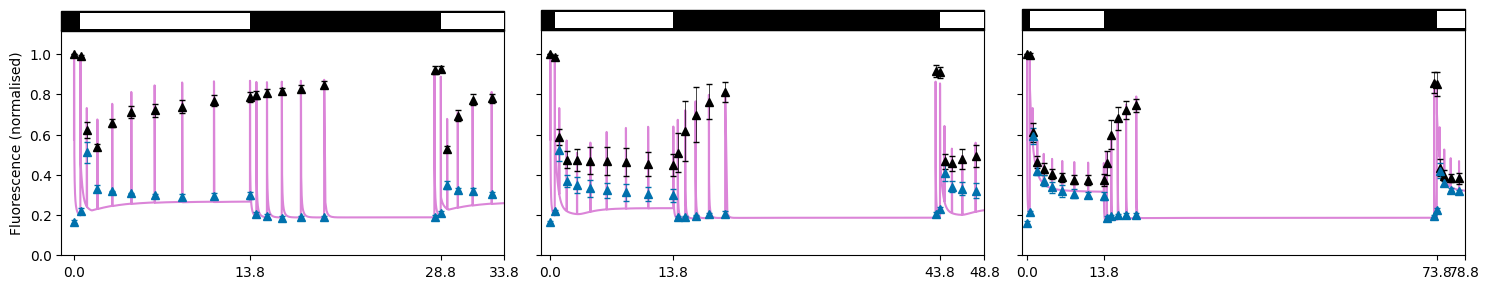

In [13]:
res = [
    {'sim': s1, 'protocol': pam_protocol1},
    {'sim': s2, 'protocol': pam_protocol2},
    {'sim': s3, 'protocol': pam_protocol3},
]

fig, axs = plt.subplots(ncols=3, figsize=(15, 3), sharey=True)

for i in range(len(axs)):
    ax = axs[i]
    c = res[i]['sim'].get_full_results()
    pam_protocol = res[i]['protocol']
    exp_data = fig4_data[i]
    
    pam_ptrc_cleaned = pam_protocol[pam_protocol['pfd'] != 5000]
    pam_ptrc_peaks = pam_protocol[pam_protocol['pfd'] == 5000]
    peaks_times = pd.Series(pam_ptrc_peaks.index).apply(lambda x: x.total_seconds())

    ax.plot(c["Fluo"] / max(c["Fluo"]), color="#db85d8")
    ax.errorbar(peaks_times, exp_data['Fm_rel_mean'][:-1], yerr=exp_data['Fm_rel_std'][:-1], marker="^", color="black", linestyle='None', elinewidth=0.5, capsize=2.5)
    ax.errorbar(peaks_times, exp_data['Ft_rel_mean'][:-1], yerr=exp_data['Ft_rel_std'][:-1], marker="^", color="#0071ad", linestyle='None', elinewidth=0.5, capsize=2.5)
    
    ax.set_xlim(-60, c.index[-1])
    ax.set_ylim(0, 1.11 * (exp_data['Fm_rel_mean'].max() + exp_data['Fm_rel_std'].iloc[exp_data['Fm_rel_mean'].idxmax()]))

    
    
    t0 = pd.Timedelta(seconds=-60)
    
    ax.add_patch(Rectangle(
            (t0.total_seconds(), ax.get_ylim()[-1]),
            width=pam_ptrc_cleaned['pfd'].index[-1].total_seconds() + 60,
            height=0.1,
            facecolor = 'black',
            edgecolor = 'black',
            lw = 1,
            clip_on=False
        ))
    
    timechanges = [['black', 0]]
    
    for t_end, val in pam_ptrc_cleaned['pfd'].items():
        t_end = cast(pd.Timedelta, t_end)
        if val == 0:
            color = 'black'
        else:
            color = 'white'
        ax.add_patch(Rectangle(
            (t0.total_seconds(), ax.get_ylim()[-1] + 0.01),
            width=t_end.total_seconds() - t0.total_seconds(),
            height=0.08,
            facecolor = color,
            clip_on=False
        ))
        
        if timechanges[-1][0] != color:
            timechanges.append([color, t0.total_seconds()])

        t0 = t_end  # type: ignore
        
    timechanges.append(['white', c.index[-1]])
    timechanges.pop(1)
    
    print(ax.get_ylim())
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
    # ticks_to_show = [0, 14, 30, 35]
    # ax.set_xticks([i * 60 for i in ticks_to_show], ticks_to_show)
    ax.set_xticks([i[-1] for i in timechanges])

axs[0].set(
    ylabel="Fluorescence (normalised)",
)

plt.tight_layout()
plt.show()